# Create a Model with TensorFlow (WIP)
This notebook contains the steps needed to build a CNN image classifier.
 

In [91]:
from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import os

In [35]:
# fyi add ?? to see documentation 
tf.keras??

Type:            KerasLazyLoader
String form:     <KerasLazyLoader (keras_2) keras.api._v2.keras as keras mode=None>
Docstring:       AUTOGENERATED. DO NOT EDIT.
Class docstring: LazyLoader that handles routing to different Keras version.

### Check for images:

In [141]:
# set the path to your dataset
dataset_dir = './image_scrape_code/screenshots'

# append dir and folder name into a list 
image_files = [
    os.path.join(dataset_dir, filename)
    for filename in os.listdir(dataset_dir)
    if filename.endswith(".png")
]
print(len(image_files))

32


### Resize if needed:

In [ ]:
# resize
size = 224, 224

# create the dir if it doesn't exist
processed_dir = 'processed_images'
os.makedirs(processed_dir, exist_ok=True)

for i in image_files:
    try:
        im = Image.open(i)
        im.thumbnail(size, Image.Resampling.LANCZOS)
        
        # filename without the path
        filename = os.path.basename(i)
        
        # create new path for the processed image
        processed_path = os.path.join(processed_dir, filename)
        
        # save 
        im.save(processed_path, "PNG")
        
        print(f"Processed {i} saved as {processed_path}")
        
    except IOError:
        print(f"Error rescale for {i}")
        

### Add Lables:

In [140]:
# labels based on file names 
labels = [1 if "person" in filename else 0 for filename in image_files]

for l in labels:
    print(l)

0
0
1
1
0
0
1
1
1
0
1
1
0
0
1
1
1
0
0
0
1
1
0
0
0
1
1
0
0
1
1
0


## Load Data:

In [89]:
data = tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:



In [78]:
# load and preprocess the images
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (256, 256))  # resize to desired dimensions
    image = tf.cast(image, tf.float32) / 255.0  # Scale (normalize pixel values between 0 and 1)
    return image, label


In [150]:
# create a TensorFlow dataset from the image files and labels
dataset = tf.data.Dataset.from_tensor_slices((image_files, labels))
print(len(dataset))

# map the preprocessing function to the dataset
dataset = dataset.map(load_and_preprocess_image)
print(len(dataset))

# shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(image_files),reshuffle_each_iteration=False)
dataset = dataset.batch(batch_size=5) #changed to 10 from 32
print(len(dataset))
data_itr = dataset.as_numpy_iterator()
batch = data_itr.next()


print(len(batch)) #should have two
print(batch[0].shape) 
print(f'Min: {batch[0].min()} Max: {batch[0].max()}')


32
32
7
2
(5, 256, 256, 3)
Min: 0.0 Max: 1.0


### Check Lables:

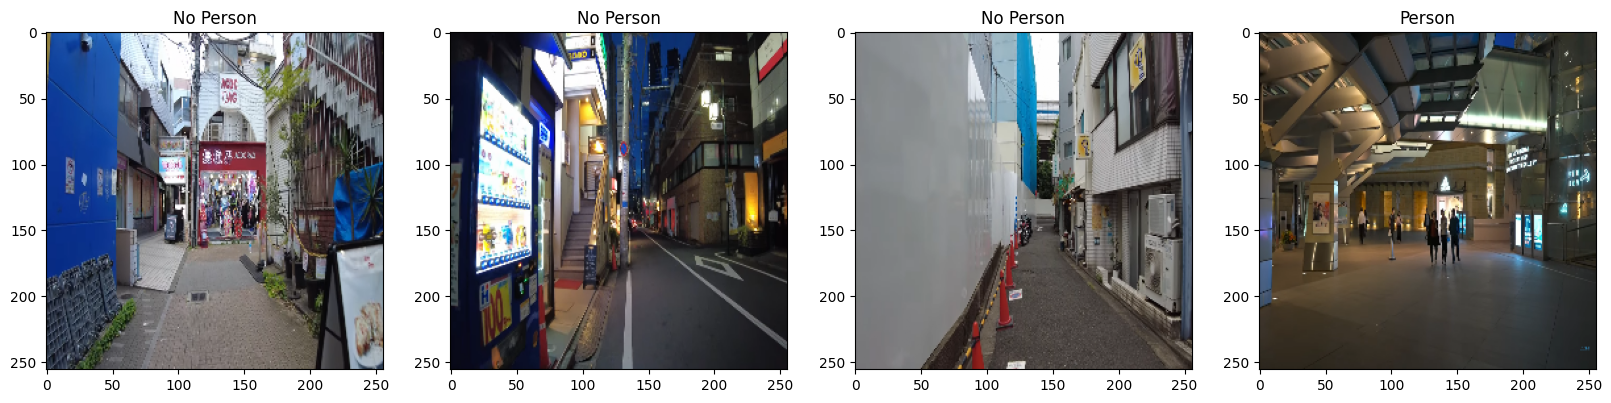

In [151]:

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, (img, label) in enumerate(zip(batch[0][:4], batch[1][:4])):
    ax[idx].imshow(img)
    title = "Person" if label == 1 else "No Person"
    ax[idx].title.set_text(title)
plt.show()


In [152]:
dataset.as_numpy_iterator().next()

(array([[[[0.57254905, 0.5058824 , 0.25490198],
          [0.57254905, 0.5058824 , 0.25490198],
          [0.58431375, 0.50980395, 0.25882354],
          ...,
          [0.11727941, 0.08590686, 0.11335784],
          [0.09019608, 0.05882353, 0.08627451],
          [0.08345588, 0.05245098, 0.0759804 ]],
 
         [[0.57254905, 0.5058824 , 0.25208333],
          [0.57254905, 0.5058824 , 0.25490198],
          [0.57365197, 0.5058824 , 0.25490198],
          ...,
          [0.11090686, 0.07953431, 0.10416666],
          [0.08627451, 0.05490196, 0.08235294],
          [0.08345588, 0.05208333, 0.07671569]],
 
         [[0.57254905, 0.5058824 , 0.2509804 ],
          [0.57254905, 0.5058824 , 0.25490198],
          [0.57254905, 0.5058824 , 0.24889706],
          ...,
          [0.10563725, 0.07634804, 0.09987745],
          [0.08627451, 0.05490196, 0.08235294],
          [0.08235294, 0.05098039, 0.07450981]],
 
         ...,
 
         [[0.16985294, 0.20906863, 0.26213235],
          [0.15294

In [153]:
len(dataset)

7

In [154]:
train_size = int(len(dataset)* .7)
val_size = int(len(dataset)*.2) +1
test_size = int(len(dataset)*.1) + 1

In [155]:
print(f'train: {train_size}, Val: {val_size},test:  {test_size}')

train: 4, Val: 2,test:  1


In [156]:
train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size+val_size).take(test_size)

### Build Model:

In [157]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten



In [158]:
model = Sequential()

In [159]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu' ))
model.add(Dense(1,activation='sigmoid' ))

In [160]:
#tf.optimizers??
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [161]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

In [162]:
logdir='logs'

In [163]:
#for logging how the model training performs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [165]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


4/4 [==============================] - 2s 247ms/step - loss: 1.3992 - accuracy: 0.6000 - val_loss: 0.9332 - val_accuracy: 0.6000
Epoch 2/20
4/4 [==============================] - 1s 201ms/step - loss: 0.9311 - accuracy: 0.5500 - val_loss: 0.7674 - val_accuracy: 0.4000
Epoch 3/20
4/4 [==============================] - 1s 242ms/step - loss: 0.5591 - accuracy: 0.7000 - val_loss: 0.6814 - val_accuracy: 0.6000
Epoch 4/20
4/4 [==============================] - 1s 201ms/step - loss: 0.4497 - accuracy: 0.8500 - val_loss: 0.7421 - val_accuracy: 0.4000
Epoch 5/20
4/4 [==============================] - 1s 196ms/step - loss: 0.2284 - accuracy: 1.0000 - val_loss: 0.7422 - val_accuracy: 0.6000
Epoch 6/20
4/4 [==============================] - 1s 198ms/step - loss: 0.0969 - accuracy: 1.0000 - val_loss: 1.0634 - val_accuracy: 0.5000
Epoch 7/20
4/4 [==============================] - 1s 201ms/step - loss: 0.0299 - accuracy: 1.0000 - val_loss: 1.4333 - val_accuracy: 0.5000
Epoch 8/20
4/4 [===============

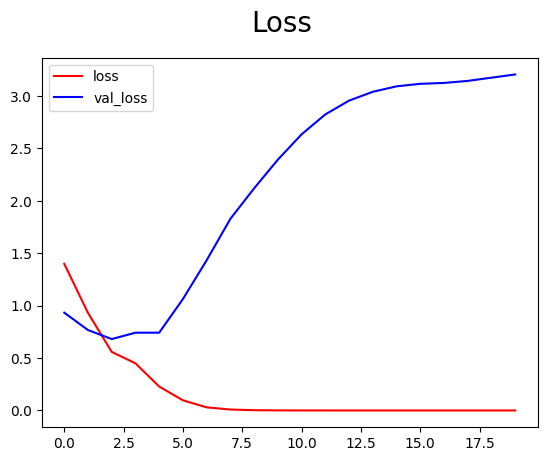

In [170]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='blue', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


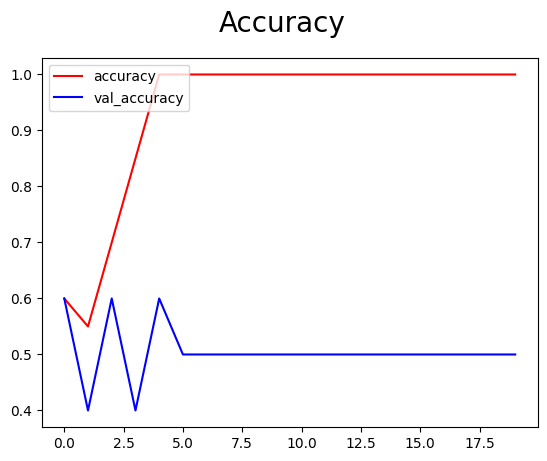

In [171]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='red', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Test:

In [172]:
import cv2

In [200]:
# set the path to your dataset
test_dir = './image_scrape_code/test_images'

# append dir and folder name into a list 
test_image_files = [
    os.path.join(test_dir, filename)
    for filename in os.listdir(test_dir)
    if filename.endswith(".png")
]
print(len(test_image_files))

2


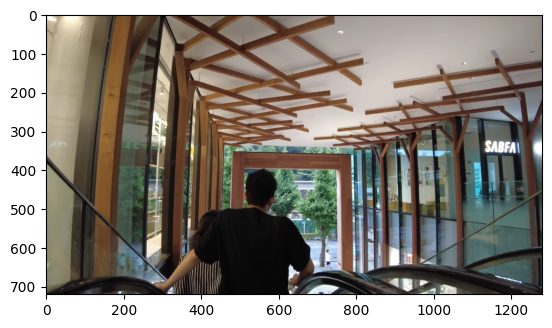

In [201]:
image = test_image_files[0]
img = cv2.imread(image)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

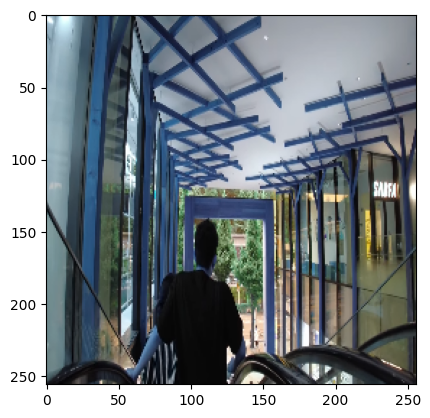

In [202]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [203]:
#the no.expand puts into another array. Our model expects a batch not a sinlge image
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 30ms/step


In [204]:
yhat

array([[0.39744088]], dtype=float32)

In [205]:
if yhat > 0.5:
    print(f'{image} has a person in it')
else:
     print(f'{image} has no person in it')

./image_scrape_code/test_images/test-person-screenshot-2024-01-28T06-06-38.732Z.png has no person in it


### Save Model:

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models', 'person_in_img_classifier.h5'))
new_model = load_model('person_in_img_classifier.h5')
new_model.predict(np.expand_dims(resize/255,0))